STAT 453: Deep Learning (Spring 2020)  

Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


- Runs on CPU or GPU (if available)

# 01 -- Fully-Connected Autoencoder on MNIST

A simple, single-layer autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations).

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.01
num_epochs = 15
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32


##########################
### MNIST DATASET
##########################


custom_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transform,
                               download=True)a

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


## Model

In [3]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        

    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.tanh(logits)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [4]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/015 | Batch 000/235 | Cost: 1.4234
Epoch: 001/015 | Batch 050/235 | Cost: 0.2128
Epoch: 001/015 | Batch 100/235 | Cost: 0.1655
Epoch: 001/015 | Batch 150/235 | Cost: 0.1316
Epoch: 001/015 | Batch 200/235 | Cost: 0.1279
Time elapsed: 0.17 min
Epoch: 002/015 | Batch 000/235 | Cost: 0.1196
Epoch: 002/015 | Batch 050/235 | Cost: 0.1084
Epoch: 002/015 | Batch 100/235 | Cost: 0.1035
Epoch: 002/015 | Batch 150/235 | Cost: 0.0966
Epoch: 002/015 | Batch 200/235 | Cost: 0.0925
Time elapsed: 0.34 min
Epoch: 003/015 | Batch 000/235 | Cost: 0.0888
Epoch: 003/015 | Batch 050/235 | Cost: 0.0826
Epoch: 003/015 | Batch 100/235 | Cost: 0.0814
Epoch: 003/015 | Batch 150/235 | Cost: 0.0792
Epoch: 003/015 | Batch 200/235 | Cost: 0.0749
Time elapsed: 0.51 min
Epoch: 004/015 | Batch 000/235 | Cost: 0.0723
Epoch: 004/015 | Batch 050/235 | Cost: 0.0736
Epoch: 004/015 | Batch 100/235 | Cost: 0.0712
Epoch: 004/015 | Batch 150/235 | Cost: 0.0704
Epoch: 004/015 | Batch 200/235 | Cost: 0.0612
Time elapse

## Evaluation

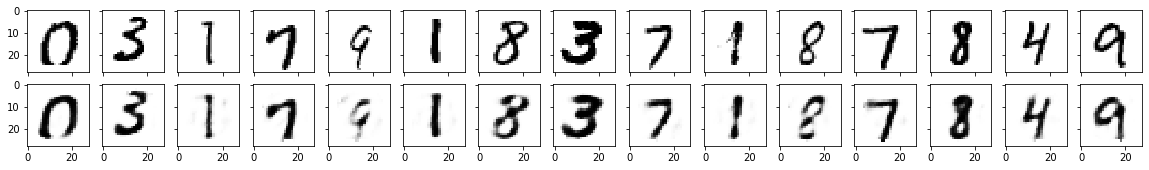

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [6]:
%watermark -iv

numpy       1.17.4
torchvision 0.5.0
torch       1.4.0
matplotlib  3.1.0

